In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
# sns.set()
# sns.set_style("white")
# sns.set_palette("GnBu_d")
%matplotlib inline

import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
import math
import random
from pathlib import Path

import geopy
from geopy.geocoders import GoogleV3
from geopy.distance import geodesic

In [2]:
df_cluster = pd.read_csv("../boston_2016_prep_cluster.csv")
# df_cluster = df

In [3]:
len(df_cluster)

1227562

In [4]:
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

613781

In [5]:
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

306890

In [6]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

153445

In [7]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

76722

In [8]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

38361

In [9]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

19180

In [10]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

9590

### 1.5) Clustering

In [11]:
df_cluster.head(1)

,level_0,index,Unnamed: 0,Unnamed: 0.1,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,...,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start,weekday_end
0,1,127,133,133,2016-01-01 15:37:34,2016-01-01 15:41:59,178,68,MIT Pacific St at Purrington St,Central Square at Mass Ave / Essex St,...,"(42.35957320109044, -71.10129475593567)","(42.36507, -71.1031)",0.628436,265.0,8.53724,3.568588,3.751808,15,4,4


We can see that over time our dataframe has become quite feature rich

But for clustering we can only use a handful of features, therefore the following columns need to be dropped:

`start_time, end_time:` we use the start hour and duration of a trip instead

`start_station_id, end_station_id, start_station_name, end_station_name:` hold no valuable information for clustering

`bike_id:` we are focusing on trips and not the different bikes

`start_coordinates, end_coordinates:` can not be used for clustering as the algorithms can not know what these coordinates mean - instead we are using start_distance_center and end_distance_center

In [12]:
df_cluster.drop(['Unnamed: 0.1','index','level_0','Unnamed: 0','start_time','end_time','start_station_id','end_station_id','start_station_name','end_station_name','bike_id','start_coordinates','end_coordinates','weekday_end'], axis=1, inplace=True)

Now we can see the 8 remaining features

In [13]:
df_cluster.head(0)

,user_type,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start


We can expect to find some interesting clusters with the features above.<br>
`user type` will tell us if the rider is a subscriber who are very likely to use the service on a daily basis or if the rider is a customer who are likely to be tourists or casual users of the service.<br>
With `distance_km` we can differntiate long from short trips which should be interesting in combination with `start_distance_center,end_distance_center`<br>
`start_distance_center,end_distance_center` can inform us about the relative start and end location of a trip.<br>
`speed_kmh` should be informative as well. A commute trip can be expected to be fast and a tourist/casual is more likely to ride slower.<br> 
We have seen in 1.4 that during week days we can observe peek usage at 8am and 5pm - we can expect these to be commuting trips. With the `start_hour` feature we hope to find these pattern in a cluster. <br>
Furthermore we have observed that peek usage during the week is much higher than on weekends - we should be able to highlight this with the feature `weekday_start`.

In order to use `user type` in a clustering algorithm we have to transform the string type to a number type: 

In [14]:
df_cluster['user_type'] = df_cluster['user_type'].replace(['Customer','Subscriber'],[0,1])

`user type` can now be read as: <br>
Customer => 0 <br>
Subscriber => 1

In [15]:
# df_cluster['weekday_start'] = df_cluster['weekday_start'].replace([0,1,2,3,4,5,6],[0,0,0,0,0,1,1])
# df_cluster['weekday_end'] = df_cluster['weekday_end'].replace([0,1,2,3,4,5,6],[0,0,0,0,0,1,1])
# 0 -> workday
# 1 -> weekend 

We have tried to leave some features out and keep others, the following code is just for quick enabling/disabling of features:

In [16]:
# df_cluster.drop(['duration_sec'], axis=1, inplace=True)
# df_cluster.drop(['speed_kmh'], axis=1, inplace=True)
# df_cluster.drop('start_hour', axis=1, inplace=True)
# df_cluster.drop("user_type", axis=1, inplace=True)
# df_cluster.drop('weekday_start', axis=1, inplace=True) 
# df_cluster.drop(['start_distance_center','end_distance_center'], axis=1, inplace=True) 

In [17]:
# df_cluster['start_hour'] = df_cluster['start_hour'].replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],[0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,2,2,2,0,0,0,0,0])
## 0 => any hour that is not rush hour <br>
## 1 => hours 7,8,9 <br>
## 2 => hours 16,17,18

#### All Cluster

Now we can get to clustering:<br>
For the unsupervised learing case we have decided to use the K-Means algorithm.<br>
Please refer to the report for reasoning.<br>
Thanks to the K-Means versatility we were able to use most of the code from workshop 11 - Introduction to Unsupervised Learning and Clustering

In [18]:
X = df_cluster

In order to use the K-Means algorithm we have to scale the data by normalizing it:

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head(10)

,user_type,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start
0,0.504395,-1.008155,-0.799021,-0.246020,0.298006,0.415031,0.244671,0.638154
1,0.504395,-0.993714,-0.905811,0.745708,0.538105,0.415031,-1.227744,1.165458
2,0.504395,1.525618,0.385495,0.669484,0.524305,-1.275986,0.665361,1.165458
3,0.504395,-0.723424,-0.671155,0.097741,0.401341,-0.114384,-0.596709,1.692763
4,-1.982572,-0.532588,-0.554531,0.106882,-0.348141,0.286918,0.875706,1.692763
5,-1.982572,-0.593642,-0.510972,-0.213836,0.152718,0.415031,-0.807054,-1.471064
6,-1.982572,-0.593642,-0.565771,-0.007502,0.401341,0.166911,0.665361,-1.471064
7,0.504395,-0.757894,-0.585443,-0.376319,0.926265,0.415031,-1.017399,-0.943760
8,-1.982572,-1.015472,-0.631812,-0.964567,1.315662,1.244745,0.455016,-0.943760
9,0.504395,-0.859711,-0.662725,-0.377529,0.881861,1.327506,1.506741,-0.943760


In [20]:
df_scaled = X_scaled_df

In [21]:
from sklearn.cluster import KMeans

To find out how many clusters we should expect we are applying two methods here: <br>
1. Expert knowledge 
2. Residual loss - elbow method <br>

After working with the trip data extensively we have a rough idea of how many trip archetypes we can expect. <br>
The features we have access to make location related data very limited, therefore we can only expect to see clusters for inner city trips, outer city trips and trips that connect inner and outer city. <br>
Furthermore do we expect to have mostly two main users: <br>
 - commuters (they would be faster und ride during weekdays)
 - casuals/tourists (they would be slower and ride during weekdays and weekends)<br>
Combining these factors we do not expect to see more than 10 clusters.

For good measure we will still perform the Residual loss / Elbow method with a max k of 50:

In [22]:
k_max = 50

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

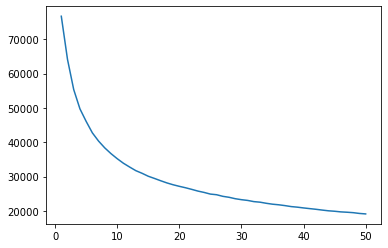

In [23]:
plt.plot(clusters, losses)
plt.show()

(0.0, 20.0)

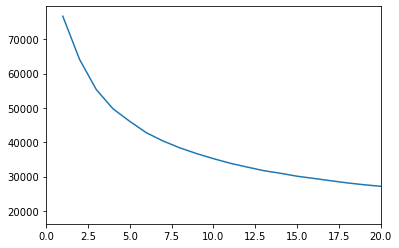

In [24]:
plt.plot(clusters, losses)
plt.xlim([0,20])

In [25]:
numbers = ["zero", "one", "two", "three","four","five","six"]

In [26]:
# # refit algorithm
# two_means = KMeans(n_clusters=2)
# two_means.fit(X_scaled)

# # match records to clusters by calling predict
# # two_means.predict(X_scaled)

# df_scaled["clusters"] = two_means.predict(X_scaled)
# df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
# sns.pairplot(data=df_scaled, hue="clusters")

In [27]:
# three_means = KMeans(n_clusters=3)
# three_means.fit(X_scaled)
# df_scaled["clusters"] = three_means.predict(X_scaled)
# df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
# sns.pairplot(data=df_scaled, hue="clusters")

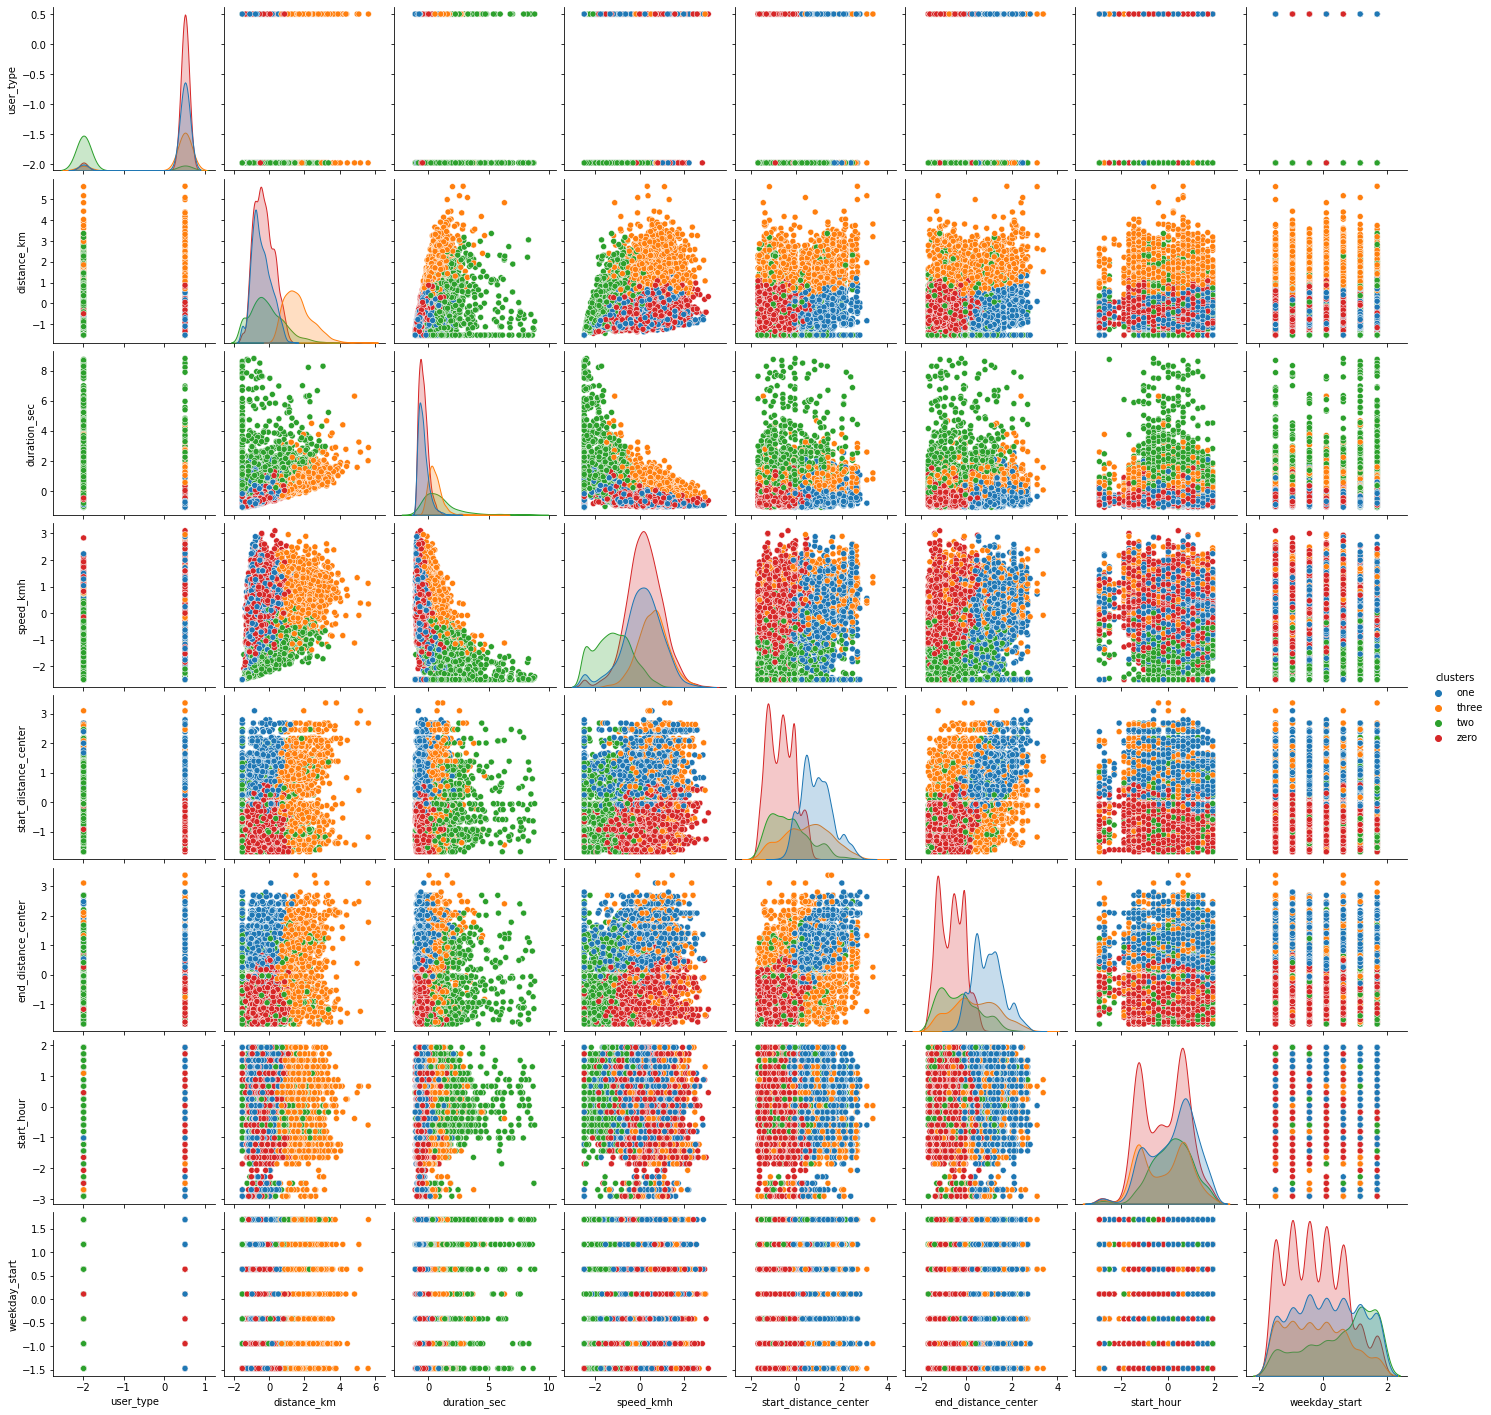

In [28]:
four_means = KMeans(n_clusters=4)
four_means.fit(X_scaled)
df_scaled["clusters"] = four_means.predict(X_scaled)
df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=df_scaled, hue="clusters")

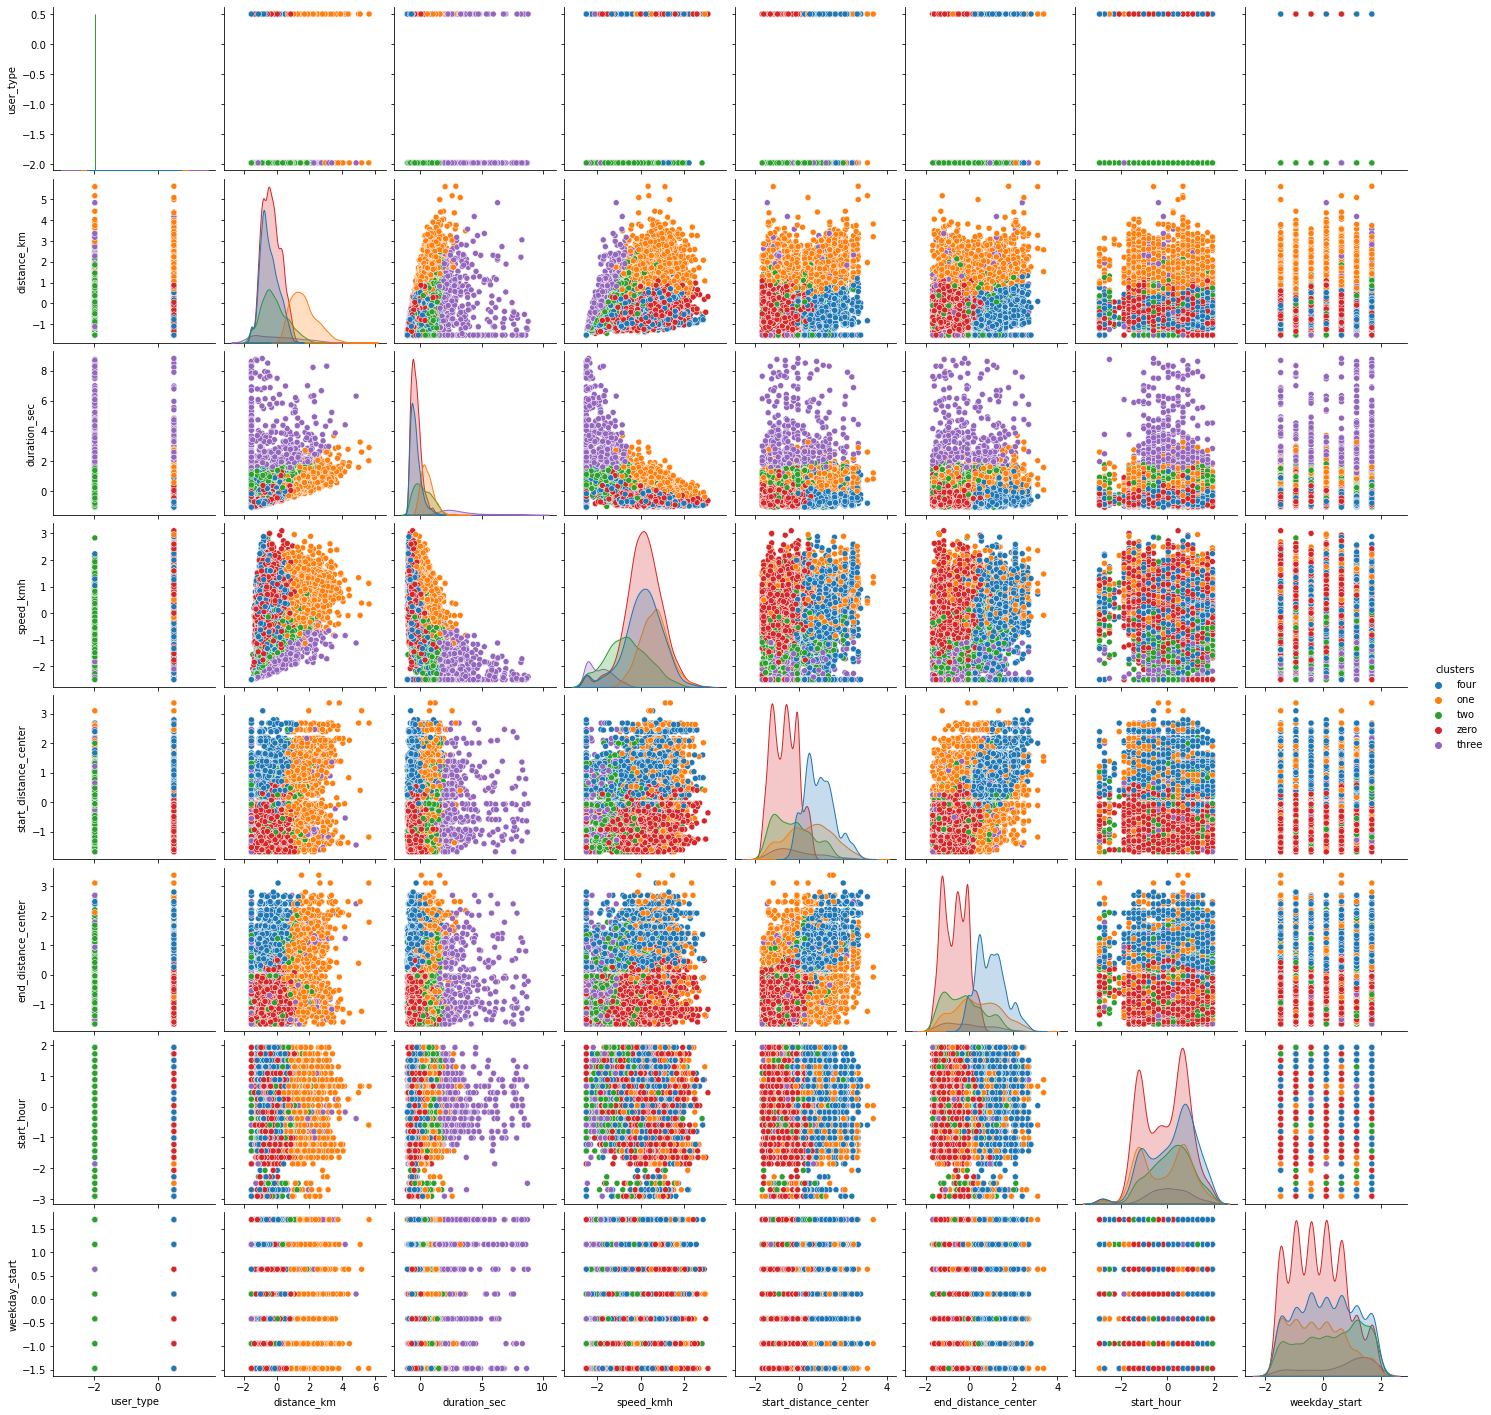

In [29]:
five_means = KMeans(n_clusters=5)
five_means.fit(X_scaled)
df_scaled["clusters"] = five_means.predict(X_scaled)
df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
sns.pairplot(data=df_scaled, hue="clusters")

In [30]:
# six_means = KMeans(n_clusters=6)
# six_means.fit(X_scaled)
# df_scaled["clusters"] = six_means.predict(X_scaled)
# df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
# sns.pairplot(data=df_scaled, hue="clusters")

In [31]:
# seven_means = KMeans(n_clusters=7)
# seven_means.fit(X_scaled)
# df_scaled["clusters"] = seven_means.predict(X_scaled)
# df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
# sns.pairplot(data=df_scaled, hue="clusters")